In [150]:
from keras.optimizers import RMSprop
import numpy as np

In [151]:
np.random.seed(10)

noise_dim = 10

batch_size = 16
steps_per_epoch = 32
epochs = 1000

img_rows, img_cols, channels = 28, 28, 1

optimizer = RMSprop(0.0002, 0.5)

In [152]:
from keras.datasets import mnist
import os

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)


if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [153]:
from keras.models import Sequential
from keras.layers import Dense

In [154]:
hsize = [512, 256, 128]

In [155]:
def create_generator():
    model = Sequential()
    model.add(Dense(hsize[-1]))
    model.add(Dense(hsize[-2]))
    model.add(Dense(hsize[-3]))
    model.add(Dense(28*28*1))
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

In [156]:
def create_discriminator():
    model = Sequential()
    model.add(Dense(hsize[0]))
    model.add(Dense(hsize[1]))
    model.add(Dense(hsize[2]))
    model.add(Dense(28*28*1))
    model.add(Dense(1))
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

In [157]:
discriminator = create_discriminator()
generator = create_generator()

In [158]:
from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

In [162]:
gan.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 784)               568208    
_________________________________________________________________
sequential_31 (Sequential)   (None, 1)                 668065    
Total params: 1,236,273
Trainable params: 1,236,273
Non-trainable params: 0
_________________________________________________________________


In [159]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(2, 5, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Epoch: 0 	 Discriminator Loss: 3.682528018951416 		 Generator Loss: 7.853228569030762


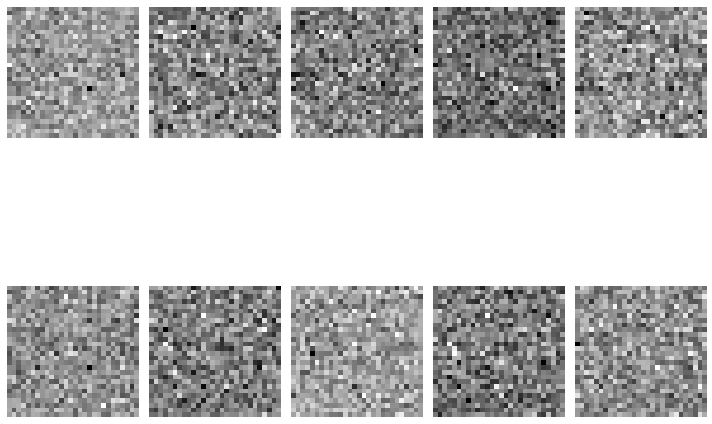

Epoch: 100 	 Discriminator Loss: 0.8461670875549316 		 Generator Loss: 0.3679961562156677


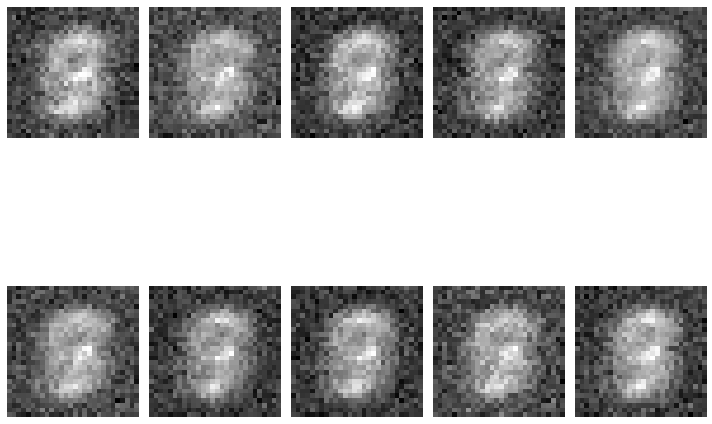

Epoch: 200 	 Discriminator Loss: 0.8520833253860474 		 Generator Loss: 0.3409988582134247


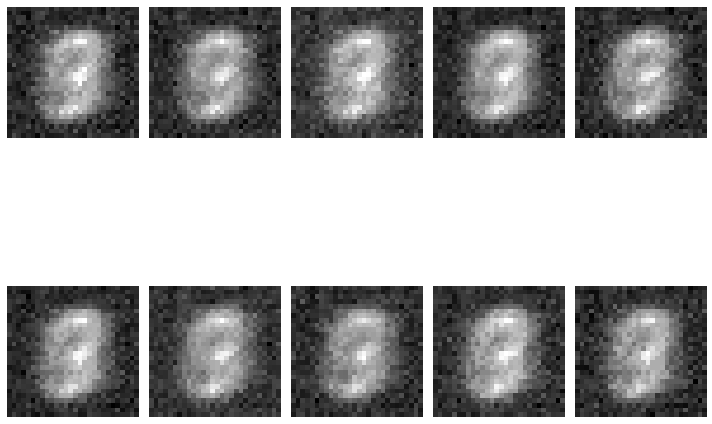

Epoch: 300 	 Discriminator Loss: 0.852621853351593 		 Generator Loss: 0.3427187204360962


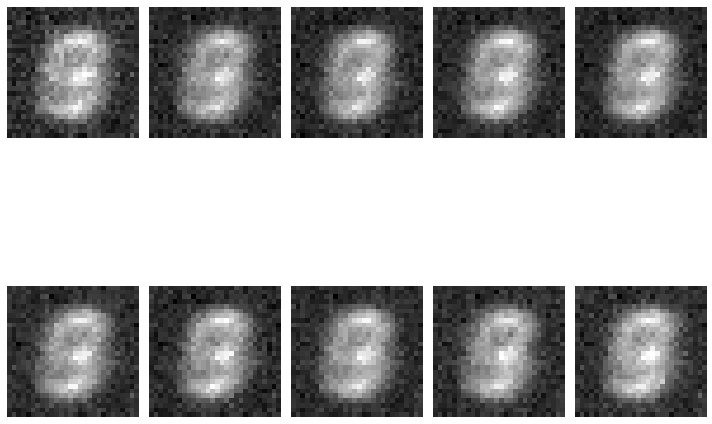

Epoch: 400 	 Discriminator Loss: 0.8544919490814209 		 Generator Loss: 0.3383709192276001


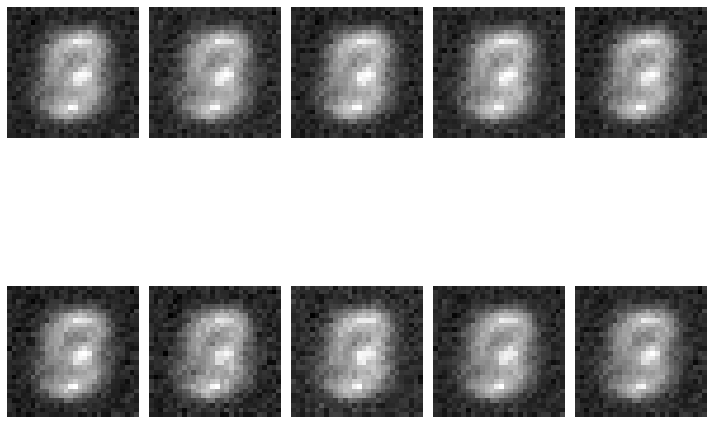

Epoch: 500 	 Discriminator Loss: 0.8553935885429382 		 Generator Loss: 0.3372616767883301


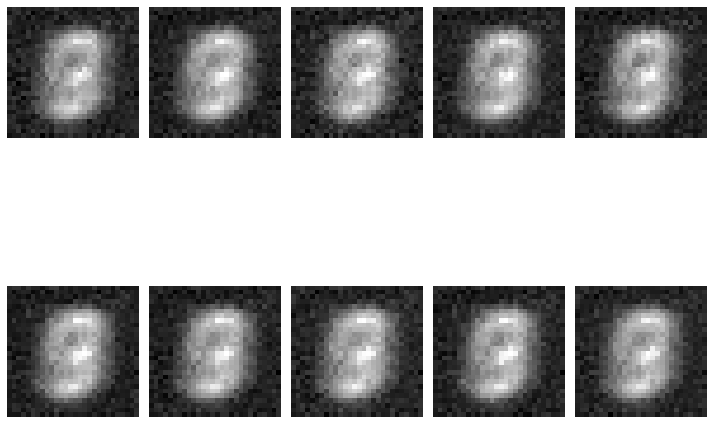

Epoch: 600 	 Discriminator Loss: 0.8555904626846313 		 Generator Loss: 0.33482205867767334


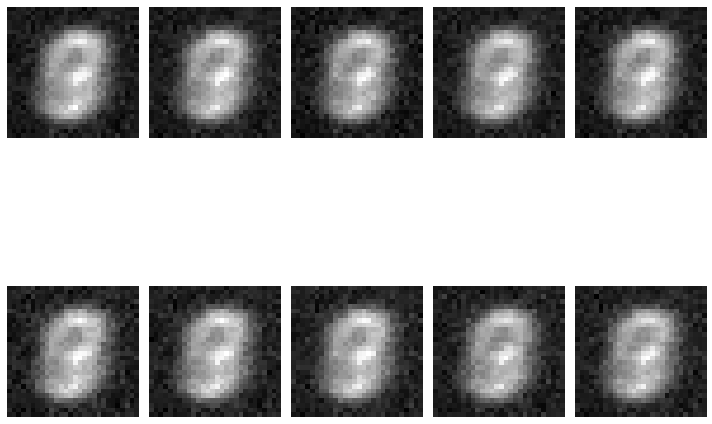

Epoch: 700 	 Discriminator Loss: 0.8559473156929016 		 Generator Loss: 0.3321189284324646


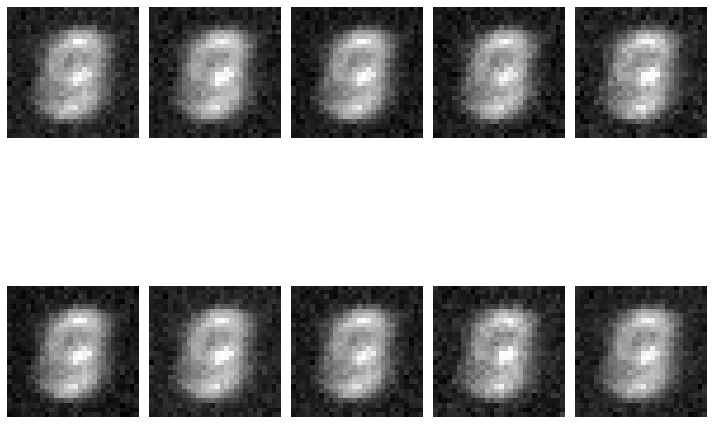

Epoch: 800 	 Discriminator Loss: 0.8539116382598877 		 Generator Loss: 0.33429455757141113


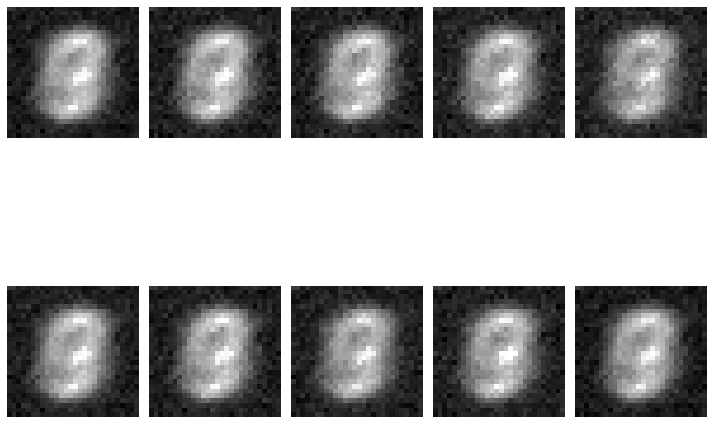

Epoch: 900 	 Discriminator Loss: 0.8557444214820862 		 Generator Loss: 0.3319351375102997


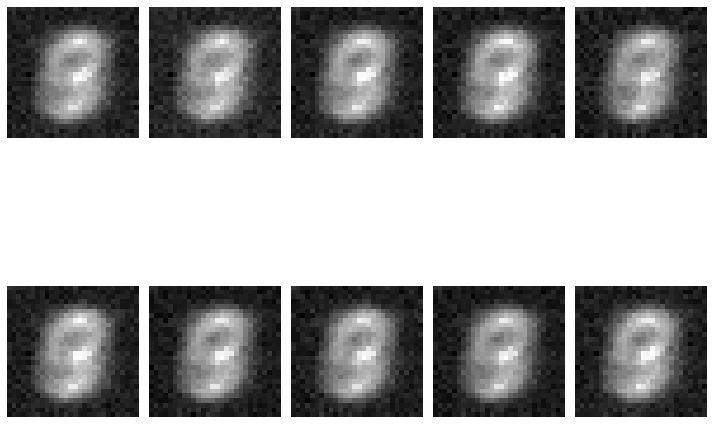

In [160]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
        noise = np.random.normal(0, 1, size=(10, noise_dim))
        show_images(noise)

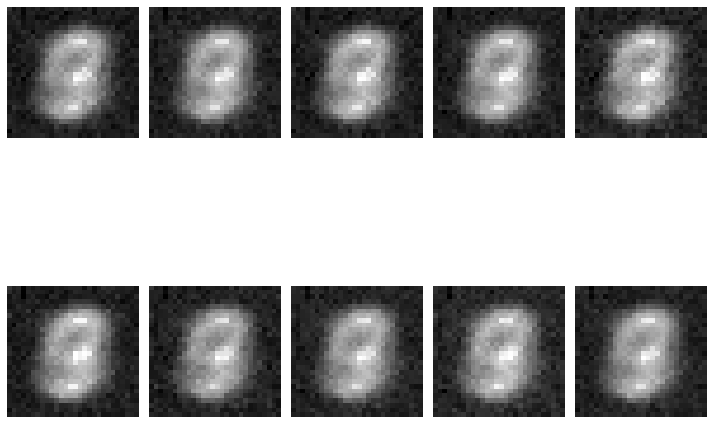

In [161]:
noise = np.random.normal(0, 1, size=(10, noise_dim))
show_images(noise)

In [181]:
import tensorflow.v1.compat as tf

c = []
a = tf.get_variable(f"a", [2, 2], initializer=tf.random_uniform_initializer(-1, 1))
b = tf.get_variable(f"b", [2, 2], initializer=tf.random_uniform_initializer(-1, 1))

with tf.device('/gpu:0'):
    c.append(tf.matmul(a, b))

with tf.device('/gpu:1'):
    c.append(a + b)

with tf.device('/cpu:0'):
    sum = tf.add_n(c)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True))

init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(sum))

ModuleNotFoundError: No module named 'tensorflow.v1'